# Простой пример модели детектирования акустических событий

## Импортируем необходимые библиотеки

In [ ]:
import numpy as np
from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa.display import specshow
from librosa import power_to_db
import os
import matplotlib.pyplot as plt

from utils.preprocessing import extract_log_mel_feats

## Скачивание данных и подготовка к обучению

Скачать архив с данными можно, перейдя по [ссылке](https://www.kaggle.com/c/freesound-audio-tagging/data). Для скачивания потребуется авторизация на [kaggle.com](https://www.kaggle.com/). 

Затем необходимо положить данные для трейна и теста в папки data/audio_train и data/audio_test соответственно, так же в корень папки необходимо положить файл train.csv, который также можно найти в архиве. 

Далее задаются различные параметры для извлечения фичей из файлов - частота дискретизации, с которой мы будем работать, размер окна и перекрытия для быстрого преобразования Фурье и число мел-коэффициентов. 

При работе со звуком в основном принято использовать не "сырые" данные - значения амплитуд в каждый момент времени, а извлекать из файлов какие-нибудь признаки (хотя, конечно, существуют успешные примеры работы и на прямую с сырыми данными, например, [WaveNet](https://arxiv.org/pdf/1609.03499.pdf)). Обычно для этого требуется переход в спектральную область, который осуществляется при помощи [преобразования Фурье](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/). Затем можно извлекать различные признаки - спектрограммы, мелспектрограммы, mfcc-коэффициенты. Мы будем работать с мелспектрограммами, о чем подробнее чуть ниже.  

In [1]:
train_folder = '/projects/data/data_v_7_stc/audio'
test_folder = '/projects/data/data_v_7_stc/test'


sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

## Визуализация фичей, используемых при обучении, для одного файла

Для начала посмотрим на признаки звуков, которые будут использоваться для классификации. 

Для извлечения фичей будем использовать популярную библиотеку [librosa](https://librosa.github.io/librosa/). Она позволяет производить множество операции с аудиофайлами - от загрузки и ресемплинга до добавления разных звуковых эффектов, например, [pitch shift](https://en.wikipedia.org/wiki/Pitch_shift) и [time stretch](https://en.wikipedia.org/wiki/Audio_time_stretching_and_pitch_scaling), которые кстати [можно использовать для аугментации](https://arxiv.org/pdf/1608.04363.pdf).

Мы будем пользоваться мелспектрограммами, а точнее логарифмом мелспектрограмм. Подробнее о том, что такое мелспектрограммы и мел-фильтры можно почитать, например, [в этом посте на хабре](https://habr.com/ru/post/226143/). Кратко - [википедия гласит](https://en.wikipedia.org/wiki/Mel_scale), что мел-шкала - шкала, основанная на восприятии звука человеком. Дело в том, что высота звука, воспринимаямая человеком, нелинейно зависит от частоты и считается, с помощью такой шкалы удается поточнее отобразить эту зависимость. 

Чтобы понять, зачем брать логарифм, нужно увидеть изображение спектрограммы до и после.

In [2]:
wav_data, sr = load_wav(os.path.join(train_folder, 'ring_0149.wav'), sr=sample_rate)

mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
                          fmax=sample_rate//2)

plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма звонка')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы звонка')
plt.tight_layout()
plt.show()

NameError: name 'load_wav' is not defined

Как получились эти различия в спектрограммах не так важно. Самое главное - мы видим, что для скрипки в логарифме мелспектрограммы прослеживается некоторая закономерность гораздо лучше, чем если мы будем использовать просто мелспектрограмму. 
Именно поэтому именно логарифм мелспектрограммы мы будем использовать в качестве признаков для всех имеющихся аудио.

## Извлечение признаков


Для ускорения вычислений нам будет полезно вычислить все мелспектрограммы заранее и сохранить их. Выполнение данной ячейки займет некоторое время, так как процесс вычисления признаков дорогой. Размер полученных файлов будет приблизительно 1 гб каждый (при исходных значениях параметров).

In [4]:
path_to_csv = os.path.join('./data', 'train.csv')
pickle_train_path = os.path.join('./data', 'train.pickle')
pickle_test_path = os.path.join('./data', 'test.pickle')

label_to_id = extract_log_mel_feats('train', path_to_csv, train_folder, pickle_train_path, sample_rate, fft_size, hop, mels)
extract_log_mel_feats('test', '', test_folder, pickle_test_path, sample_rate, fft_size, hop, mels)

Total files: 9473


9473it [56:54,  2.77it/s]
9400it [47:36,  2.75it/s]


## Создаем модель

Для начала импортируем необходимые классы из keras и из нашей небольшой утилиты. 

Сама модель сети (класс CNNModel) имеет довольно простую архитектуру - всего три слоя свертки, чередующиеся с пулингом. Конечно, используем такие модные и успешные штуки как [batch normalization](https://arxiv.org/pdf/1502.03167.pdf) и [dropout](https://arxiv.org/pdf/1207.0580.pdf).

In [5]:
import pickle


from model.batcher import Batcher
from model.config import Config
from model.cnn_model import CNNModel
from model.utils import prepare_shape

from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


Создаем класс конфига для удобной передачи параметров в класс модели: задаем входные размеры фичей, шаг обучения и число выходных классов.

Далее подгружаем ранее извлеченные признаки.

In [6]:
config = Config(shape=(64, 63, 1), learning_rate=0.001, n_classes=41)

pickle_train_data = pickle.load(open(pickle_train_path, 'rb'))

Выделяем валидационную выборку для контроля обучения. 

In [7]:
validation_set_size = 1000

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(pickle_train_data):
    feature = prepare_shape(row['feature'], config)
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])
x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

## И, наконец, начинем обучение!


In [ ]:
train_batcher = Batcher(x_tr, y_tr, batch_size=100)
val_batcher = Batcher(x_val, y_val)

checkpoint = ModelCheckpoint('./best_weights.h5', monitor='val_loss',
                             verbose=0, save_best_only=True)

model = CNNModel(config).get_model()

history = model.fit_generator(train_batcher,
                              callbacks=[checkpoint, TQDMNotebookCallback()],
                              validation_data=val_batcher,
                              epochs=30,
                              use_multiprocessing=False,
                              workers=0,
                              verbose=0)

## Визуализируем процесс обучения.

Воспользуемся удобными интерфейсами keras для визулизации процесса обучения. Метод *fit_generator* возвращает объект *history*, который хранит полученные в конце каждой эпохи значения ошибки и точности.

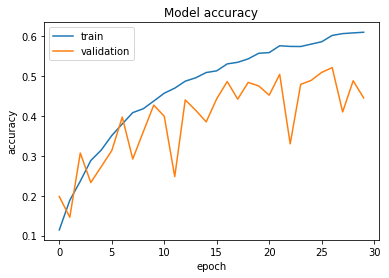

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

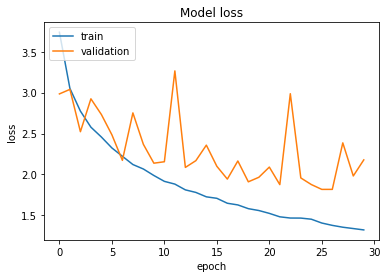

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Формируем файл для отправки на kaggle

Считываем тестовые данные.

In [16]:
pickle_test_data = pickle.load(open(pickle_test_path, 'rb'))
x_test = []

for i, row in enumerate(pickle_test_data):
    feature = prepare_shape(row['feature'], config)
    x_test.append(feature)

x_test = np.asarray(x_test)

Загружаем веса обученной модели, делаем предсказание и сохраняем в файл.

In [17]:
pred_file_name = './base_submission.csv'

model.load_weights('./best_weights.h5')
config = Config(shape=(64, 63, 1), learning_rate=0.001, n_classes=41)

pred_batcher = Batcher(x_test)

predictions = model.predict_generator(pred_batcher,
                                      use_multiprocessing=False,
                                      workers=0)
res = np.argsort(predictions)
id_to_label = {i: label for label, i in label_to_id.items()}
with open(pred_file_name, 'w') as f:
    f.write('fname,label\n')
    for i, row in enumerate(res):
        row = row[::-1]
        f.write('{},{} {} {}\n'.format(pickle_test_data[i]['fname'],
                                       id_to_label[row[0]],
                                       id_to_label[row[1]],
                                       id_to_label[row[2]]))

## Готово! 

Теперь в рабочей директории появился файл с предсказаниями для тестовой выборки - его можно смело отправлять на kaggle. Модель выдает результат около 60%, сравнимый с точностью базового решения, предложенного авторами конкурса.

Далее, например, попробовать улучшить модель: поиграться с архитектурой сети, входными данными - использовать другое число мел-коэффициентов или, например, другие признаки. Также стоит попробовать увеличить частоту дискретизации - изначально файлы имеют частоту дискретизации 44,1 кГц, мы специально уменьшили её до 11,025 кГц - для увеличения скорости работы, однако, для получения лучшего качества классификации не стоит делать передискретизацию до таких маленьких значений.

